### Research Paper Implementation: TwoScale Realized Volatility Estimation
Paper is as follows:
Zhang, Lan, Per A. Mykland, and Yacine Aït-Sahalia. "A tale of two time scales: Determining integrated volatility with noisy high-frequency data." Journal of the American Statistical Association 100, no. 472 (2005): 1394-1411.
http://public.econ.duke.edu/~get/browse/courses/201/spr09/DOWNLOADS/MicroStructureNoise/AS-Zhang-Mykland-AS-2005.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['lines.linewidth'] = 2


**1. Read Data**

In [6]:
factor_df = pd.read_csv('factor_raw_data.csv',index_col = 0)

In [7]:
factor_df.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1965-03-31,-1.34,2.03,1.09,-0.30,0.73,0.36
1,1965-04-30,3.11,1.18,0.71,0.26,-2.30,0.31
2,1965-05-31,-0.77,0.06,-1.63,-0.37,0.70,0.31
3,1965-06-30,-5.51,-4.30,0.55,0.12,0.41,0.35
4,1965-07-31,1.43,1.07,2.18,-1.41,-0.02,0.31


In [8]:
factor_df.tail()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
654,2019-09-30,1.44,0.32,6.71,1.97,3.55,0.18
655,2019-10-31,2.06,0.21,-2.07,0.43,-0.96,0.15
656,2019-11-30,3.87,0.50,-1.86,-1.50,-1.29,0.12
657,2019-12-31,2.77,0.96,1.83,0.21,1.31,0.14
658,2020-01-31,-0.11,-4.39,-6.26,-1.23,-2.33,0.13


In [9]:
factor_df.Date= pd.to_datetime(factor_df.Date)

In [10]:
factor_df = factor_df.set_index('Date')

**2. Plot Factor Trend (from 1965 to 2020)**

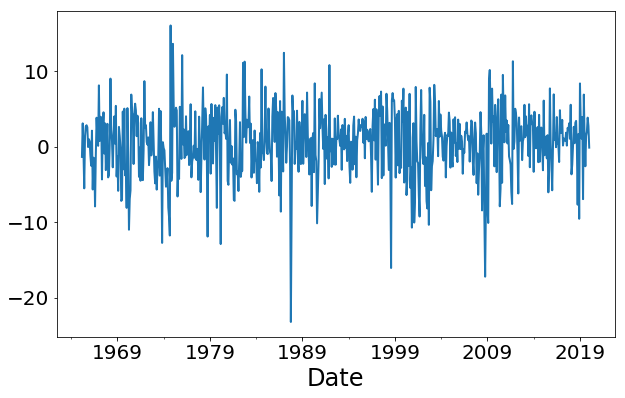

In [11]:
factor_df['Mkt-RF'].plot(figsize = (10,6))
plt.show()

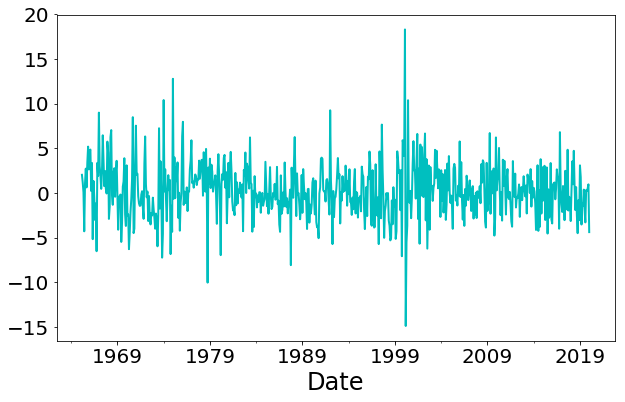

In [12]:
factor_df['SMB'].plot(figsize = (10,6),color= 'c')
plt.show()

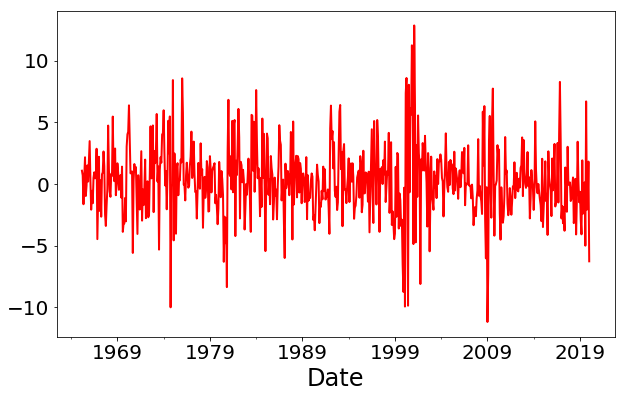

In [13]:
factor_df['HML'].plot(figsize = (10,6),color = 'r')

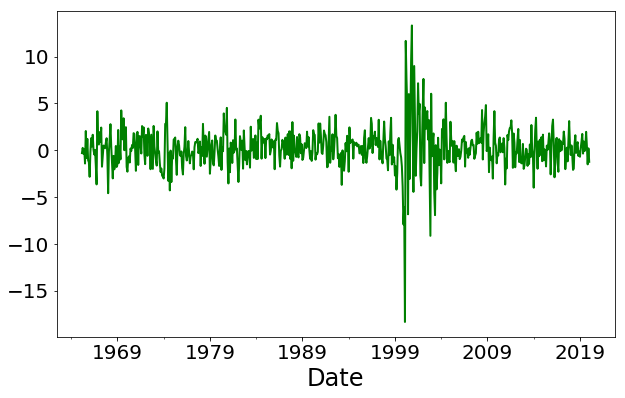

In [14]:
factor_df['RMW'].plot(figsize = (10,6),color = 'g')

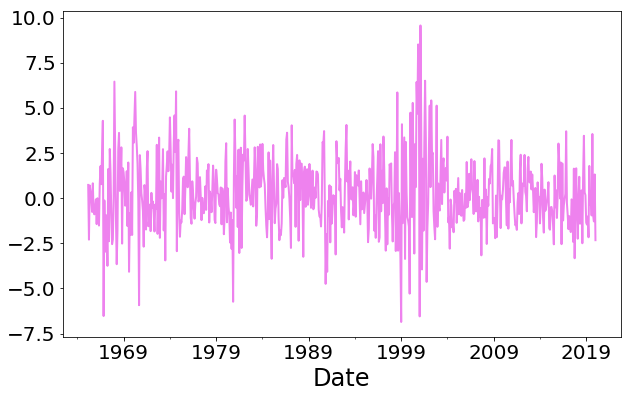

In [21]:
factor_df['CMA'].plot(figsize = (10,6),color = 'violet')

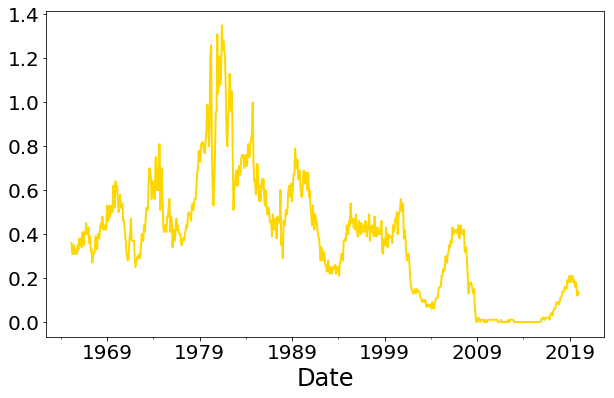

In [22]:
factor_df['RF'].plot(figsize = (10,6),color= 'gold')

**3. Compute TSRV**

In [17]:
def RV_calculation(x, n, K):
    sum_ = 0
    for i in range(n-K+1):
        sum_ += (x[i+K]-x[i])**2
    X_K_T = sum_/K
    
    X_All_T = 0
    for i in range(n+1):
        X_All_T += (x[i+1]-x[i])**2
        
    z = (n-K+1)/K
    TSRV = (1-z/n)**(-1)*abs(X_K_T - z/n*X_All_T)
    
    RV = np.sqrt(TSRV)
    return RV

In [19]:
def TSRV_stratrgy(RV_col = ['SMB','HML','RMW','CMA'], weight_rf=0.3):
    RV_df = pd.DataFrame(columns =RV_col)

    start_number = 298
    k  = 6
    for col in RV_col:
        RV = []
        for i in range(start_number,len(factor_df)-k):
            x = factor_df[col][i-start_number:i].reset_index(drop = True)
            RV.append(RV_calculation(x,n =start_number-2,K = k))
        RV_df[col] = RV
    
    RV_df = 1/RV_df

    RV_df['sum_'] = RV_df.iloc[:,:4].sum(axis = 1)

    RV_weights = RV_df.iloc[:,:4].div(RV_df.sum_, axis=0)*(1-weight_rf)
    RV_weights['RF'] = weight_rf
    RV_weights.to_csv('factor_weights_jiaxin.csv')
    print('RV_weights:\n',RV_weights.head())
    
    
    factor_4RV = factor_df.iloc[298:-6,2:].reset_index(drop = True)
    return_RV = (factor_4RV*RV_weights).sum(axis =1)
    return_benchmark = (factor_df.iloc[:,2:].sum(axis= 1)/5)[298:-6].reset_index(drop = True)
    
    plt.plot(return_RV - return_benchmark)
    
    
    print('\nBenchmark_difference',np.sum(return_RV - return_benchmark))


RV_weights:
         SMB       HML       RMW       CMA   RF
0  0.199064  0.159056  0.160736  0.181144  0.3
1  0.200246  0.159258  0.161639  0.178856  0.3
2  0.203521  0.156685  0.161254  0.178540  0.3
3  0.204725  0.157280  0.160662  0.177333  0.3
4  0.213683  0.154247  0.158062  0.174008  0.3

Benchmark_difference 2.3381090003746503


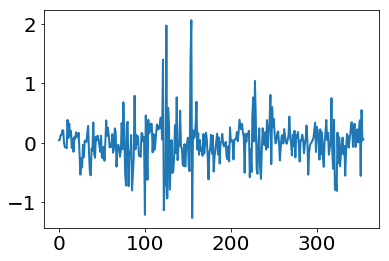

In [20]:
TSRV_stratrgy()